In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week17_lipschitz_cora_full'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [5]:
print(len(experiments))

2800


In [6]:
list(experiments[0]['metrics'].keys())

['val_member_0_cross_entropy-val-0',
 'val_member_0_accuracy-val-0',
 'val_member_0_loss-val-0',
 'ensemble_accuracy-val-0',
 'accuracy_val__val',
 'accuracy_id_val__val',
 'accuracy_ood_val__val',
 'accuracy_val_no-edges_val',
 'accuracy_id_val_no-edges_val',
 'accuracy_ood_val_no-edges_val',
 'ece_val__val',
 'ece_val_no-edges_val',
 'empirical_lipschitz_val_slope_mean_perturbation_noise_val',
 'empirical_lipschitz_val_slope_median_perturbation_noise_val',
 'empirical_lipschitz_val_slope_max_perturbation_noise_val',
 'empirical_lipschitz_val_slope_min_perturbation_noise_val',
 'empirical_lipschitz_val_slope_mean_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_median_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_max_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_min_perturbation_no-edges_val',
 'auroc_feature-distance_input-loc_val',
 'aucpr_feature-distance_input-loc_val',
 'auroc_structure_loc_val',
 'aucpr_structure_loc_val',
 'accuracy_ood-va

In [7]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'


RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Norm'
WEIGHT_SCALE = 'Weight Scale'
LOWER_LIPSCHITZ = 'Empirical Lower Lipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper Lipschitz Bound'



EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'

In [8]:
mode = 'test'

In [9]:
epistemic_proxy = 'gpc-diag-mode:weighted-relative:False:no_fit-95conf'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = 'AUROC'

In [32]:
data_proxy, data_acc_ece = [], []


for ex in experiments:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        RESIDUAL : cfg['model']['residual'],
        SPECTRAL_NORM : cfg['model']['use_spectral_norm'],
        WEIGHT_SCALE : cfg['model']['weight_scale'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
    }
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}__{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}__{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == 'max-score':
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base | {
                    ACCURACY : ex['metrics'][f'accuracy_{mode}__{mode}'][0],
                    ECE : ex['metrics'][f'ece_{mode}__{mode}'][0]['value'],
                }
                )
            

In [33]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [34]:
df_acc_ece[(df_acc_ece[WEIGHT_SCALE] == 20.0) & (df_acc_ece[RESIDUAL] == True)][LOWER_LIPSCHITZ].mean(), \
    df_acc_ece[(df_acc_ece[WEIGHT_SCALE] == 20.0) & (df_acc_ece[RESIDUAL] == False)][LOWER_LIPSCHITZ].mean()

(0.9553656246576268, 0.09817050903783003)

In [35]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 4, }, log_x = True, binned=True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones with spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            if binned:
                mean, bin_edges, bin_idx = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], statistic='mean', bins=10)
                std, _, _ = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], bins=bin_edges, statistic='std')
                bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
                if log_x:
                    bin_centers = np.exp(bin_centers)
                
            else:
                bin_centers = np.sort(np.unique(x_style))
                mean = np.array([(y_style[x_style == center]).mean() for center in bin_centers])
                std = np.array([(y_style[x_style == center]).std() for center in bin_centers])
               
            plot_mask = np.isfinite(mean) & np.isfinite(std)

            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
             
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 1.25), frameon=False)
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.1, 0.99), frameon=False)
    
    
    lines, line_labels = [], []
    for style, marker in style_to_marker.items():
        lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
        line_labels.append(style)
    l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm', loc='center left', frameon=False, bbox_to_anchor=(1.1, 0.7))
    
    g.axes.flatten()[-1].add_artist(l1)
    g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        g.set(xscale='log')
    return g


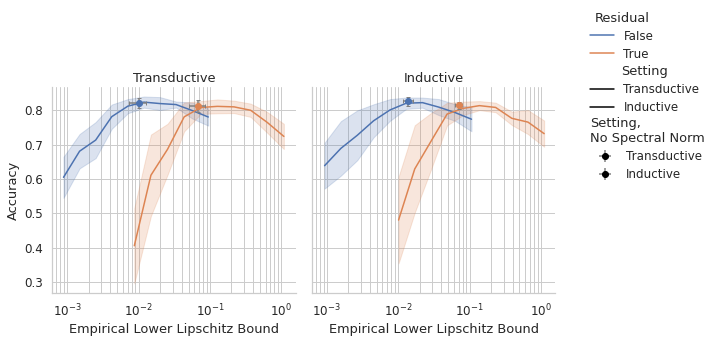

In [29]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_acc_ece,
    x = LOWER_LIPSCHITZ, y = ACCURACY, col = SETTING, row = None, hue = RESIDUAL, style = SETTING, binned=True, log_x=True)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

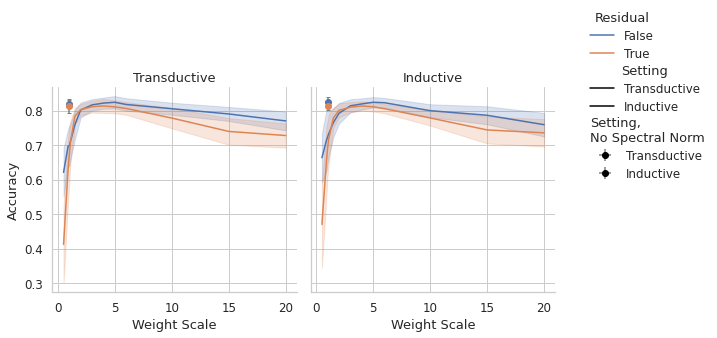

In [30]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_acc_ece,
    x = WEIGHT_SCALE, y = ACCURACY, col = SETTING, row = None, hue = RESIDUAL, style = SETTING, binned=False, log_x=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

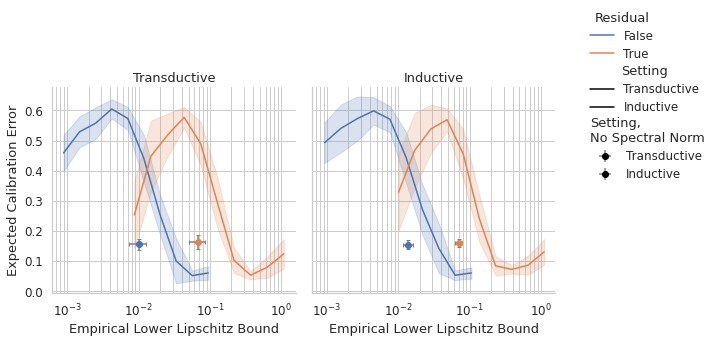

In [27]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_acc_ece,
    x = LOWER_LIPSCHITZ, y = ECE, col = SETTING, row = None, hue = RESIDUAL, style = SETTING, binned=True, log_x=True)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

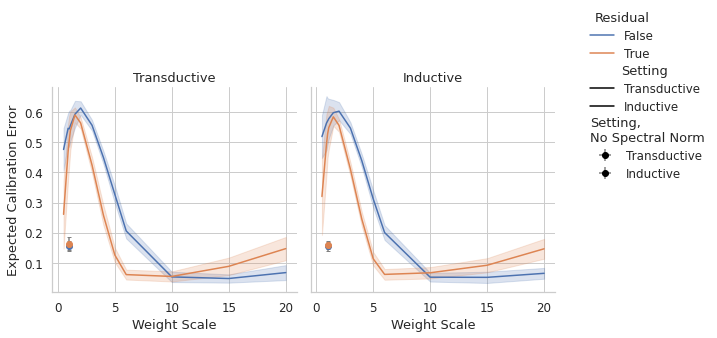

In [28]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_acc_ece,
    x = WEIGHT_SCALE, y = ECE, col = SETTING, row = None, hue = RESIDUAL, style = SETTING, binned=False, log_x=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

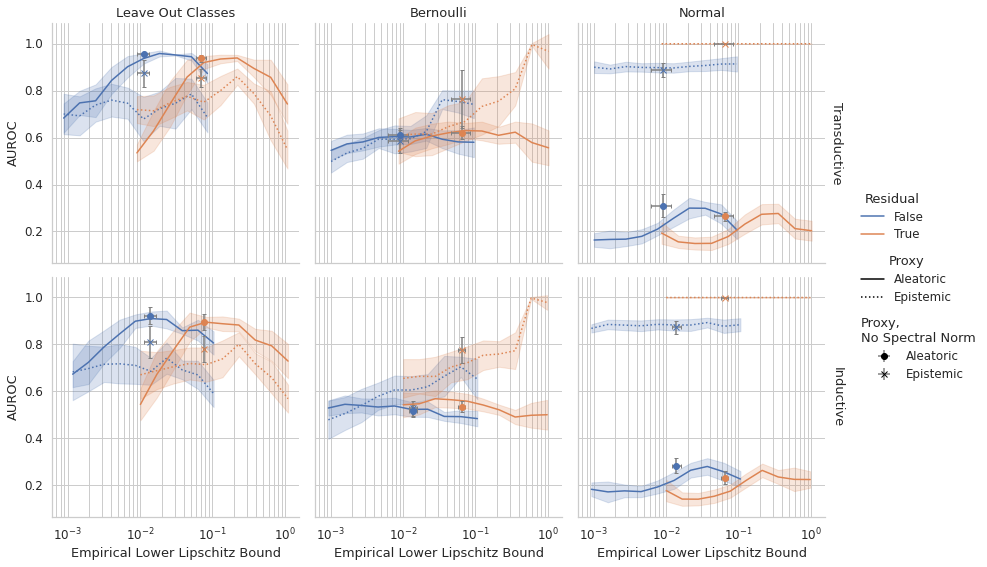

In [15]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[(df_proxy[NO_EDGES] == False)],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SETTING, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

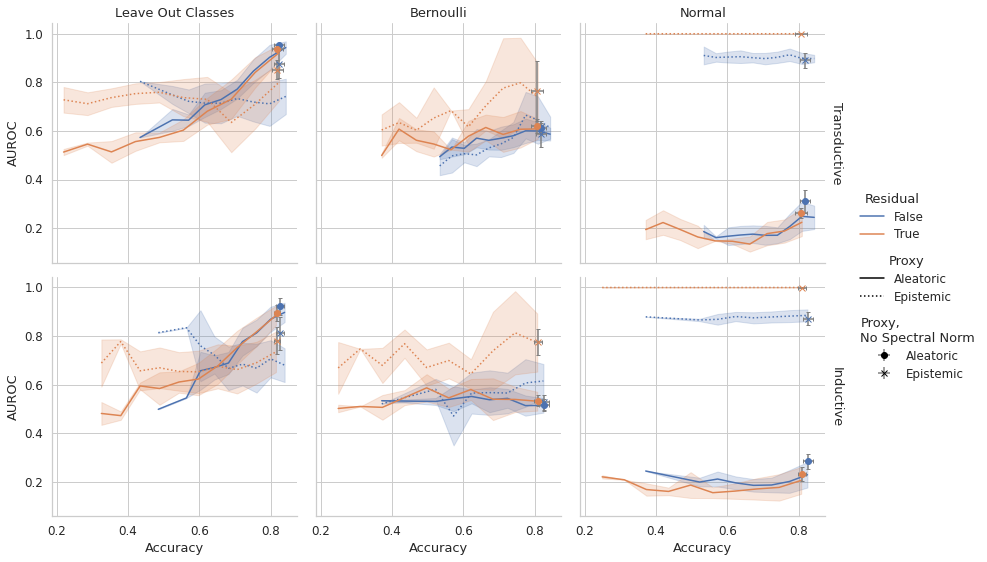

In [37]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[(df_proxy[NO_EDGES] == False)],
    x = ACCURACY, y = METRIC, col = EXPERIMENT, row = SETTING, hue = RESIDUAL, style = PROXY, log_x=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

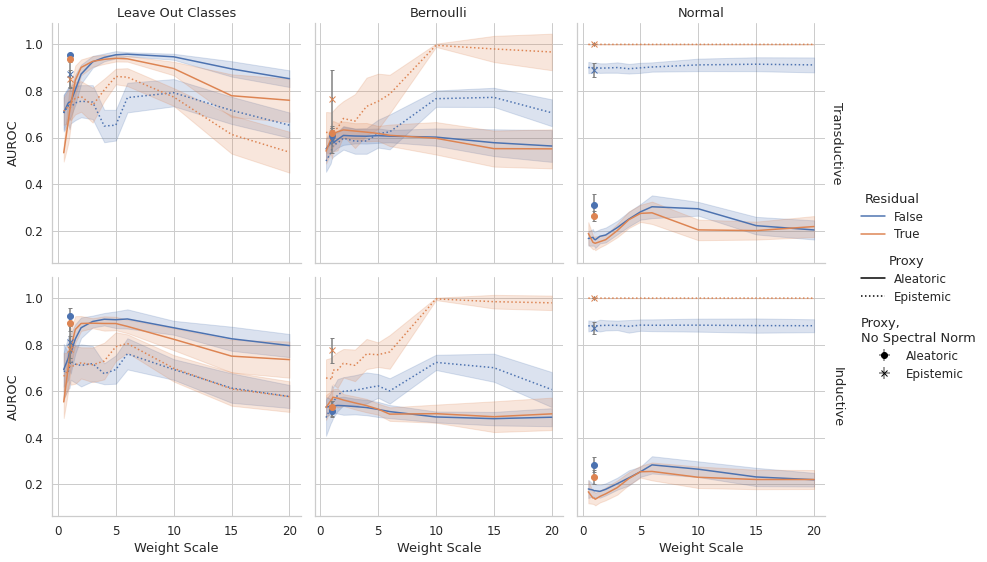

In [16]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[(df_proxy[NO_EDGES] == False)],
    x = WEIGHT_SCALE, y = METRIC, col = EXPERIMENT, row = SETTING, hue = RESIDUAL, style = PROXY,
    binned=False, log_x=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

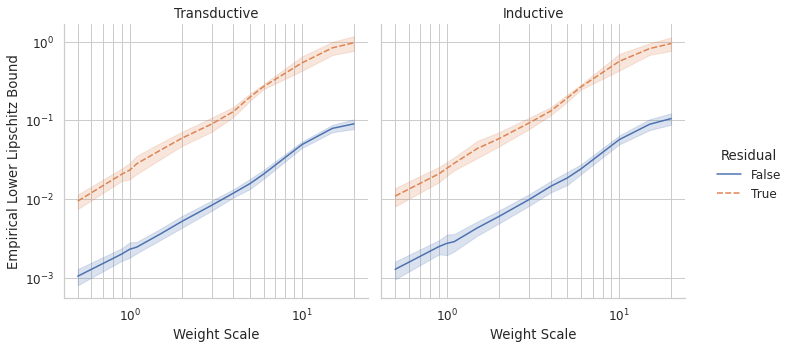

In [18]:

sns.set(context='notebook', font_scale=1.1)
sns.set_style("whitegrid")
g = sns.relplot(data = df_acc_ece[df_acc_ece[SPECTRAL_NORM] == True] , 
                x = WEIGHT_SCALE, y = LOWER_LIPSCHITZ, hue = RESIDUAL, col = SETTING, 
                row = None, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci='sd')
g.set(xscale='log')
g.set(yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

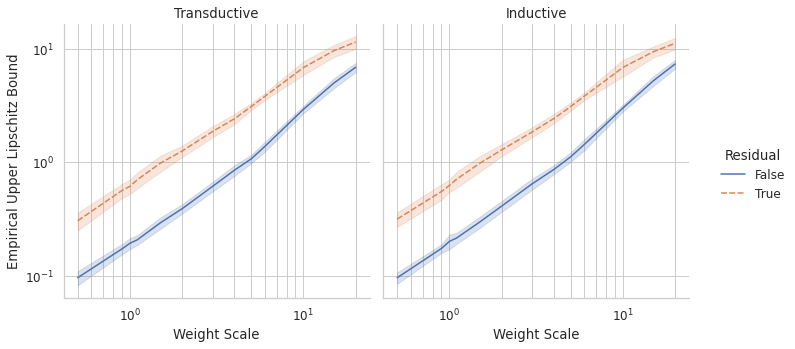

In [38]:

sns.set(context='notebook', font_scale=1.1)
sns.set_style("whitegrid")
g = sns.relplot(data = df_acc_ece[df_acc_ece[SPECTRAL_NORM] == True] , 
                x = WEIGHT_SCALE, y = UPPER_LIPSCHITZ, hue = RESIDUAL, col = SETTING, 
                row = None, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci='sd')
g.set(xscale='log')
g.set(yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')